In [26]:
import os
os.chdir('../')

from src.K_means import *
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

In [2]:
def inpute_data(X, k):
    # Inpute the data which misses values with a k-nearest neighboor search
    imputer = KNNImputer(n_neighbors=k)
    return imputer.fit_transform(X)

In [3]:
def compute_confusion_matrix(clusters:np._typing.NDArray, true_clusters:np._typing.NDArray, k:int)->np._typing.NDArray:
    #  at index i, j: number of elements of cluster i classified as being in cluster j
    N = clusters.shape[0]
    confusion_matrix = np.zeros((k, k))
    for i in range(N):
        confusion_matrix[true_clusters[i], clusters[i]] += 1
    return confusion_matrix

In [22]:
def create_test_dataset_missing_data(d: int, n_points: int, mu_list: list, p: float) -> np._typing.NDArray:
    # return K-mixture model with n points in each cluster and delete data with proportion p for each point
    K = len(mu_list)
    X = [0.5 * np.random.randn(d, n_points) + mu_list[k][:, np.newaxis] for k in range(K)]
    X = np.hstack(X)
    mask = np.random.binomial(1, p, (d, len(mu_list) * n_points))
    X[np.where(mask)] = np.nan
    true_clusters = np.hstack([np.full(n_points, k, dtype=np.int8) for k in range(K)])
    return X, true_clusters

In [23]:
d = 10
K=4
#[np.zeros(d), 100 * np.ones(d), -50 * np.ones(d), -30 * np.ones(d)]
n = 1000
N = n*K

{0.01: array([3856.22, 3856.22, 3856.22, 3856.22]), 0.05: array([3822.1, 3822.1, 3822.1, 3822.1]), 0.1: array([3776.42, 3776.42, 3776.42, 3776.42]), 0.25: array([3530.66, 3530.66, 3530.66, 3530.66]), 0.5: array([2554.62, 2554.62, 2554.62, 2554.62]), 0.75: array([1599.74, 1599.74, 1599.74, 1599.74])}
{0.01: array([3856.26, 3856.26, 3856.26, 3856.26]), 0.05: array([3822.1, 3822.1, 3822.1, 3822.1]), 0.1: array([3776.52, 3776.52, 3776.52, 3776.52]), 0.25: array([3531.3, 3531.3, 3531.3, 3531.3]), 0.5: array([2561.8, 2561.8, 2561.8, 2561.8]), 0.75: array([1602.34, 1602.34, 1602.34, 1602.34])}


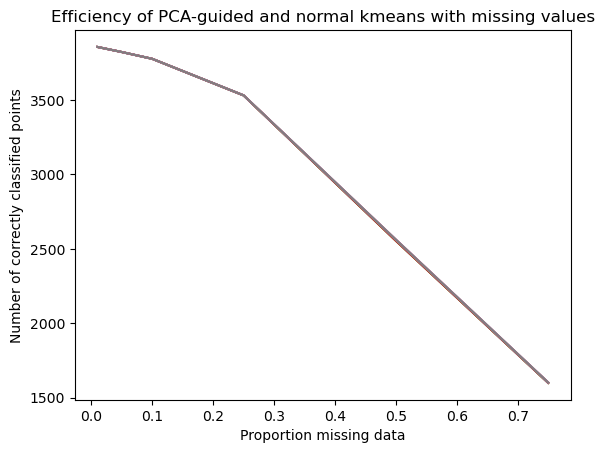

In [36]:
missing_data_proportion=[1e-2, 5*1e-2, 1e-1, 2.5*1e-1, 5*1e-1, 7.5*1e-1]
nbr_samples = 50
number_correctly_classified_plus_plus={p: np.zeros(K) for p in missing_data_proportion}
number_correctly_classified_pca={p: np.zeros(K) for p in missing_data_proportion}
for it_samples in range(nbr_samples):
    kmeans_plus_plus = {p: generalized_Kmeans(K, 'kmeans++', epochs=50) for p in missing_data_proportion}
    kmeans_pca = {p: generalized_Kmeans(K, 'guided_PCA', epochs=2) for p in missing_data_proportion}
    confusion_matrix_plus_plus = dict()
    confusion_matrix_pca = dict()
    
    for p in missing_data_proportion:
        X, true_clusters = create_test_dataset_missing_data(d, n, mu_list, p)
        X = inpute_data(X, 5)
        # Kmeans++
        kmeans_plus_plus[p].fit(X.transpose())
        clusters_plus_plus = kmeans_plus_plus[p].predict(X.transpose())
        clusters_plus_plus = np.round(clusters_plus_plus).astype(int)
        confusion_matrix_plus_plus[p] = compute_confusion_matrix(clusters_plus_plus, true_clusters, K)
        number_correctly_classified_plus_plus[p] = number_correctly_classified_plus_plus[p]+np.sum(np.max(confusion_matrix_plus_plus[p], axis=1))
        
        # PCA-Guided Kmeans
        kmeans_pca[p].fit(X.transpose())
        clusters_pca = kmeans_pca[p].predict(X.transpose())
        clusters_pca = np.round(clusters_pca).astype(int)
        confusion_matrix_pca[p] = compute_confusion_matrix(clusters_pca, true_clusters, K)
        number_correctly_classified_pca[p] = number_correctly_classified_pca[p]+np.sum(np.max(confusion_matrix_pca[p], axis=1))
for p in missing_data_proportion:
    number_correctly_classified_plus_plus[p]/=nbr_samples
    number_correctly_classified_pca[p]/=nbr_samples
print(number_correctly_classified_plus_plus)
print(number_correctly_classified_pca)

plt.plot(list(number_correctly_classified_plus_plus.keys()), list(number_correctly_classified_plus_plus.values()))
plt.plot(list(number_correctly_classified_pca.keys()), list(number_correctly_classified_pca.values()))
plt.xlabel("Proportion missing data")
plt.ylabel("Number of correctly classified points")
plt.title("Efficiency of PCA-guided and normal kmeans with missing values")
plt.show()